## 1. Packages and Parameters

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm
from utils.visualize import show_loss
from utils.data import collate_EP

import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# hyperparameters
BATCH_SIZE = 256
EPOCH = 100
LEARNING_RATE = 2e-5
MAX_FRAME = 200
DIM_TOKEN = 256
NUM_HEAD = 8
DROPOUT_PROB = 1e-1

# dictionary for classification
dict_class = {
    'action': ['bodylower', 'bodyscratch', 'bodyshake',
               'feetup', 'footup', 'heading', 'lying',
               'mounting', 'sit', 'tailing', 'taillow',
               'turn', 'walkrun'],
    'emotion': ['aggresive', 'feared', 'anxiety',
                'relaxed', 'excited', 'offended'],
}
num_action = len(dict_class['action'])
num_emotion = len(dict_class['emotion'])

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## 2. Dataset

### 2.1 Load label

In [99]:
label_train = pd.read_pickle('data/key_label_train')
label_val = pd.read_pickle('data/key_label_val')

### 2.2 Dataset and dataloader

In [75]:
class KeyDataset(Dataset):
    def __init__(self, label):
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.label.iloc[idx].values

In [100]:
# dataset for training
train_dataset = KeyDataset(label_train)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    #num_workers=4,
    pin_memory=True
)

In [79]:
# dataset for validation and test
temp_dataset = KeyDataset(label_val)

dataset_size = len(temp_dataset)
val_size = int(dataset_size * 0.5)
test_size = dataset_size - val_size

val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    #num_workers=4,
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    #num_workers=4,
    pin_memory=True
)

### 3.3 Check for a batch

In [101]:
train_keys = next(iter(train_dataloader))

In [102]:
print(train_keys.keys())
print(train_keys['keys'].shape)
print(train_keys['action'].shape)
print(train_keys['emotion'].shape)

dict_keys(['keys', 'action', 'emotion'])
torch.Size([256, 14, 15, 3])
torch.Size([256, 13])
torch.Size([256, 6])


## 3. Emotion Prediction
    - Input: ...
    - Output: ...

### 3.1 Model define

In [82]:
from torch.nn import TransformerEncoder as trEnc
from torch.nn import TransformerEncoderLayer as trEncLayer

In [83]:
class EPencoder(nn.Module):
    def __init__(self, C_in):
        super().__init__()
        
        # layers
        self.encoder_layer = trEncLayer(d_model=DIM_TOKEN,
                                        nhead=DIM_TOKEN // NUM_HEAD,
                                        activation='gelu',
                                        batch_first=True,
                                        norm_first=True)
        self.encoder = trEnc(encoder_layer=self.encoder_layer, 
                             num_layers=6)
        self.mlp_action = self.get_MLP(num_action)
        self.mlp_emotion = self.get_MLP(num_emotion)
        self.dropout = nn.Dropout(DROPOUT_PROB)
        self.linear = nn.Linear(C_in, DIM_TOKEN)
        
        # tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, MAX_FRAME + 2, DIM_TOKEN))
        self.action_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        self.emotion_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        
    def get_MLP(self, len_cls):
        return nn.Sequential(nn.LayerNorm(DIM_TOKEN),
                             nn.Linear(DIM_TOKEN, len_cls),
                             nn.Softmax(1))

    def forward(self, x):   
        x = torch.flatten(x, 2) # [B, N, 15, 3] -> [B, N, 45]
        B, N, _ = x.shape             
        x = self.linear(x)      # [B, N, 45] -> [B, N, 256]
        
        act_token = self.action_token.repeat(B, 1, 1)
        emo_token = self.emotion_token.repeat(B, 1, 1)
        x = torch.cat((act_token, emo_token, x), dim=1)
        
        x += self.pos_embedding[:, :(N + 2)]
        x = self.dropout(x)
        
        x = self.encoder(x)
        
        act_output = x[:, 0]
        emo_output = x[:, 1]
        
        return self.mlp_action(act_output), self.mlp_emotion(emo_output)

In [84]:
model_EP = EPencoder(45)
model_EP = model_EP.double().to(device)

### 3.2 Training

In [11]:
model_EP = model_EP.train()

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_EP.parameters(), lr=LEARNING_RATE)
loss_train = []
loss_val = []

In [33]:
for e in range(EPOCH):
    losses_train = []
    losses_val = []
    
    for train in train_dataloader:
        optimizer.zero_grad()
        
        out_act, out_emo = model_EP(train['keys'].to(device))
        loss_act = criterion(out_act, train['action'].to(device))
        loss_emo = criterion(out_emo, train['emotion'].to(device))
        
        loss_t = loss_act + loss_emo
        losses_train.append(loss_t.item())
        
        loss_t.backward()
        optimizer.step()        
        
    with torch.no_grad():
        for val in val_dataloader:        
            out_act, out_emo = model_EP(val['keys'].to(device))
            loss_act = criterion(out_act, val['action'].to(device))
            loss_emo = criterion(out_emo, val['emotion'].to(device))

            loss_v = loss_act + loss_emo
            losses_val.append(loss_v.item())
    
    avgLoss_train = np.mean(np.array(losses_train))
    avgLoss_val = np.mean(np.array(losses_val))
    
    loss_train.append(avgLoss_train)
    loss_val.append(avgLoss_val)
    
    if e % 5 == 0:
        print(f'Epoch {e+1}/{EPOCH} | Avg Train loss: {avgLoss_train:.4f} | Avg Val loss: {avgLoss_val:.4f}')
        
print(f'Epoch {e+1}/{EPOCH} | Avg Train loss: {avgLoss_train:.4f} | Avg Val loss: {avgLoss_val:.4f}')

Epoch 1/100 | Avg Train loss: 3.7593 | Avg Val loss: 3.9727
Epoch 6/100 | Avg Train loss: 3.7058 | Avg Val loss: 3.9714
Epoch 11/100 | Avg Train loss: 3.6927 | Avg Val loss: 3.9882
Epoch 16/100 | Avg Train loss: 3.6882 | Avg Val loss: 3.9904
Epoch 21/100 | Avg Train loss: 3.6798 | Avg Val loss: 3.9921
Epoch 26/100 | Avg Train loss: 3.6769 | Avg Val loss: 3.9964
Epoch 31/100 | Avg Train loss: 3.6731 | Avg Val loss: 3.9942
Epoch 36/100 | Avg Train loss: 3.6696 | Avg Val loss: 3.9951
Epoch 41/100 | Avg Train loss: 3.6474 | Avg Val loss: 3.9743
Epoch 46/100 | Avg Train loss: 3.6231 | Avg Val loss: 3.9619
Epoch 51/100 | Avg Train loss: 3.6019 | Avg Val loss: 3.9740
Epoch 56/100 | Avg Train loss: 3.5905 | Avg Val loss: 3.9050
Epoch 61/100 | Avg Train loss: 3.5823 | Avg Val loss: 3.8778
Epoch 66/100 | Avg Train loss: 3.5765 | Avg Val loss: 3.8973
Epoch 71/100 | Avg Train loss: 3.5725 | Avg Val loss: 3.8956
Epoch 76/100 | Avg Train loss: 3.5699 | Avg Val loss: 3.8967
Epoch 81/100 | Avg Train l

In [44]:
#torch.cuda.empty_cache()

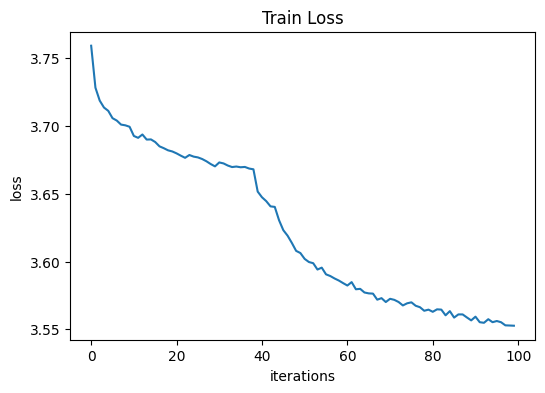

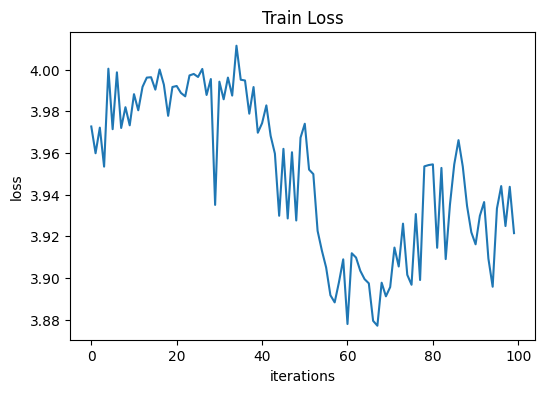

In [43]:
show_loss(loss_train)
show_loss(loss_val)

In [16]:
# saving model state
torch.save(model_EP.state_dict(), 'state/model_EP4')

In [17]:
# saving loss values
with open('state/loss_EP4_v.pkl','wb') as f:
    pickle.dump(loss_val, f)

### 3.3 Test

In [86]:
model_EP = model_EP.eval()
p = model_EP(train_keys['keys'].to(device))

In [87]:
p[1][0]

tensor([0.2040, 0.1622, 0.1962, 0.1101, 0.1070, 0.2205], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [88]:
train_keys['emotion'][0]

tensor([0., 0., 0., 1., 0., 0.])

### 3.4 Loading

In [13]:
# loading previous model state
model_EP.load_state_dict(torch.load('state/model_EP_B256_E1_L2e-5'))

<All keys matched successfully>

In [28]:
# loading previous loss values
with open('state/loss_EP3_Lin_E1.pkl','rb') as f:
    loss_train = pickle.load(f)

# Memo

Positional Embedding 문제  
Training set은 17 정도가 끝인데  
Val set은 0 ~ 178까지 다양하다  
learnable한 embedding을 사용한다면 17 이후의 embedding은 학습되지 않을 것이다.  